# Modeling Ternary Body Formation:
## The T Cell - Antigen - Tumor Cell model

### Importing the important packages to simulate the model.

In [27]:
#General imports
import random
import numpy as np
import pandas as pd

#Matplotlib specific imports
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from matplotlib import cm
from matplotlib.legend import Legend
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter

#Scipy specific imports
from scipy.integrate import odeint
from scipy.optimize import curve_fit

#Custom Functions
from F_Functions import *

### Definition of the function which handles optimization of the ODE Ternary Body model

In [28]:
def rxn(C,t):
        #Loading the global variable reaction rates
        global k
        kf1 = kf4 = k[0]                                             
        kr1 = kr4 = k[1]                                             
        kf2 = kf3 = k[2]                                             
        kr2 = kr3 = k[3]                                             
        
        #Loading the initial concentrations
        C_snap = C[0]                   #initial concentration of free T Cell receptor
        C_anti = C[1]                   #initial concentration of free antibody
        C_tumo = C[2]                   #initial concentration of free Tumor cell receptor
        C_snap_anti = C[3]              #initial concentration of bound T Cell - Antibody
        C_anti_tumo = C[4]              #initial concentration of bound Tumor Cell - Antibody
        C_snap_anti_tumo = C[5]         #initial concentration of Ternary Body
        
        #Separation of key equation terms for simplicity
        term1 = kf1 * C_snap * C_anti           #binding of Tcell to antibody
        term2 = kr1 * C_snap_anti               #dissociation of Tcell - antibody
        term3 = kf2 * C_anti * C_tumo           #binding of TumorCell to antibody
        term4 = kr2 * C_anti_tumo               #dissociation of TumorCell - antibody
        term5 = kf3 * C_snap_anti * C_tumo      #binding of Tcell-antibody to Tumor Cell
        term6 = kr3 * C_snap_anti_tumo          #dissociation of Ternary Body
        term7 = kf4 * C_anti_tumo * C_snap      #binding of TumorCell-antibody to T Cell
        term8 = kr4 * C_snap_anti_tumo          #dissociation of Ternary Body

        #ODEs that model the dynamic change in concentration of each chemical species
        d_C_snap_dt = - term1 + term2 - term7 + term8                         #change in free T Cell receptor
        d_C_anti_dt = - term1 + term2 - term3 + term4                         #change in free antibody
        d_C_tumo_dt = - term3 + term4 - term5 + term6                         #change in free Tumor cell receptor
        d_C_snap_anti_dt = + term1 - term2 - term5 + term6                    #change in bound T Cell - Antibody
        d_C_anti_tumo_dt = + term3 - term4 - term7 + term8                    #change in bound Tumor Cell - Antibody
        d_C_snap_anti_tumo_dt = + term5 - term6 + term7 - term8               #change in Ternary Body
        
        return([d_C_snap_dt,d_C_anti_dt,d_C_tumo_dt,d_C_snap_anti_dt,d_C_anti_tumo_dt,d_C_snap_anti_tumo_dt])

In [29]:
def fitfunc(ab, fit1, fit2, fit3, fit4, fit5):  #we could expand this to include the initial concentration of tumor and tcell...
    'Function that returns ABC computed from an ODE for 4 ks'
    global Concentration_of_T_Cells, Concentration_of_Tumor_Cells, k_norm_vector
    k1 = fit1 * TCell.iloc[0][1]
    k2 = fit2 * Antibodies['k_on'][type_of_antibody]
    k3 = fit3 * Antibodies['k_off'][type_of_antibody]
    C0 = fit4 * Concentration_of_T_Cells
    C2 = fit5 * Concentration_of_Tumor_Cells
    C = [C0,0,C2,0,0,0]

    def myode(C, t):
        #Loading the global variable reaction rates
        kf1 = kf4 = k1                                            
        kr1 = kr4 = 0                                            
        kf2 = kf3 = k2                                             
        kr2 = kr3 = k3                                             
        
        #Loading the initial concentrations
        C_snap = C[0]                   #initial concentration of free T Cell receptor
        C_anti = C[1]                   #initial concentration of free antibody
        C_tumo = C[2]                   #initial concentration of free Tumor cell receptor
        C_snap_anti = C[3]              #initial concentration of bound T Cell - Antibody
        C_anti_tumo = C[4]              #initial concentration of bound Tumor Cell - Antibody
        C_snap_anti_tumo = C[5]         #initial concentration of Ternary Body
        
        #Separation of key equation terms for simplicity
        term1 = kf1 * C_snap * C_anti           #binding of Tcell to antibody
        term2 = kr1 * C_snap_anti               #dissociation of Tcell - antibody
        term3 = kf2 * C_anti * C_tumo           #binding of TumorCell to antibody
        term4 = kr2 * C_anti_tumo               #dissociation of TumorCell - antibody
        term5 = kf3 * C_snap_anti * C_tumo      #binding of Tcell-antibody to Tumor Cell
        term6 = kr3 * C_snap_anti_tumo          #dissociation of Ternary Body
        term7 = kf4 * C_anti_tumo * C_snap      #binding of TumorCell-antibody to T Cell
        term8 = kr4 * C_snap_anti_tumo          #dissociation of Ternary Body

        #ODEs that model the dynamic change in concentration of each chemical species
        d_C_snap_dt = - term1 + term2 - term7 + term8                         #change in free T Cell receptor
        d_C_anti_dt = - term1 + term2 - term3 + term4                         #change in free antibody
        d_C_tumo_dt = - term3 + term4 - term5 + term6                         #change in free Tumor cell receptor
        d_C_snap_anti_dt = + term1 - term2 - term5 + term6                    #change in bound T Cell - Antibody
        d_C_anti_tumo_dt = + term3 - term4 - term7 + term8                    #change in bound Tumor Cell - Antibody
        d_C_snap_anti_tumo_dt = + term5 - term6 + term7 - term8               #change in Ternary Body
        
        return([d_C_snap_dt,d_C_anti_dt,d_C_tumo_dt,d_C_snap_anti_dt,d_C_anti_tumo_dt,d_C_snap_anti_tumo_dt])
    
    build = []
    time = np.linspace(0,86400,86400)
    for init in ab:
        C[1] = init
        C_array = odeint(myode, C, time)
        build.append(C_array[-1,5])
        
    build = [float(i)/max(build) for i in build]

    return build

### Experimental Setup

In [251]:
#User defined values to determine which simulation to run and compare against experimental values
type_of_tcell = "CAR"                #Options = "SN" for synNotch, or "CAR" for SNAP-CAR                         
type_of_antibody = "Rituximab"      #Options = "FMC63", "Rituximab", "Cetuximab", or "Herceptin"                

#Reading in the Experimental Data from the "Data" Folder
experiment = type_of_tcell + "_" + type_of_antibody                                                     
df_fit = pd.read_excel('Data/ExperimentalData.xlsx', sheet_name=experiment)

#Reading in the Literature Values from the "Data" Folder
TCell = pd.read_excel('Data/ImportantVariables.xlsx', sheet_name='TCell',index_col='TCR')
Receptors = pd.read_excel('Data/ImportantVariables.xlsx', sheet_name='Receptors',index_col='Target')
Antibodies = pd.read_excel('Data/ImportantVariables.xlsx', sheet_name='Antibodies',index_col='Antibody')

In [252]:
#normalizing the experimental data
df_data = df_fit.iloc[:,0]
df_xdata = df_data / 1e-9 / Antibodies.loc[type_of_antibody]['MW'] / 1000 / 1e6 / 1e-3 #conversion ug/mL to nM
df_ydata = (df_fit.iloc[:,10]-df_fit.iloc[:,10].min())/(df_fit.iloc[:,10].max()-df_fit.iloc[:,10].min()) #normalized to maximal ternary body formation
df_yerror = df_fit.iloc[:,12]/(df_fit.iloc[:,10].max()-df_fit.iloc[:,10].min())

In [253]:
#Average Trial Experimental Data
x_vals = df_fit.iloc[:,0].values
temp = df_fit.iloc[:,10]
y_vals_norm = (temp-temp.min())/(temp.max()-temp.min()) #normalized to maximal ternary body formation
y_vals = y_vals_norm.values
total = []
for i in range(0,len(x_vals)):
    row = [float(x_vals[i]),float(y_vals[i])]
    total.append(row)
exp_data_average = np.array(total)
# print(exp_data_average)

In [254]:
#Individual Trial Experimental Data
x_vals = df_fit.iloc[:,0].values
temp = df_fit.iloc[:,7:10]
y_vals_norm = (temp-temp.min())/(temp.max()-temp.min()) #normalized to maximal ternary body formation
y_vals = y_vals_norm.values
total = []
for i in range(0,len(x_vals)):
    for j in range(0,3):
        row = [float(x_vals[i]),float(y_vals[i][j])]
        total.append(row)
exp_data_alot = np.array(total)
# print(exp_data_alot)

In [255]:
#creating an empty list to store simulation data
data = []
antibody_nm = np.logspace(-4,2,100) #antibody in nM for simulation
# antibody_ug_axis = antibody_nm * 1/((10**-3) * (1000/Antibodies.loc[antibody]['MW']) * (10**9) ) #convert nM to ug/mL for plotting
antibody_ug_axis = antibody_nm * 1e-9 * Antibodies.loc[type_of_antibody]['MW'] * 1000 * 1e6 * 1e-3 #conversion nM to ug/mL 

#Variables given for the experimental setup
Avogadro_number = 6.022140857 * (10**23)                 #Avogadro's Number of Molecules per mole
reaction_volume = 150                                     #150 uL reaction volume
number_of_Snap_Tcells = 150000                           #150,000 T Cells in reaction
number_of_tumor_cells = 400000                          #400,000 Tumor Cells in reaction 

#Regular Parameters from before
receptor = Antibodies['Target'][type_of_antibody]
number_of_receptors_per_Tcell = 100000                          #(units = molecules per cell) Receptors per T cell
number_of_receptors_per_tumor = int(Receptors['ave'][receptor]) #(units = molecules per cell) Receptors per Tumor cell

#Calculating the initial molecular concentrations
Concentration_of_T_Cells = number_of_Snap_Tcells * number_of_receptors_per_Tcell * \
                               (10**6) * (10**9) * (1/Avogadro_number) * (1/reaction_volume) #final value in nM
Concentration_of_Tumor_Cells = number_of_tumor_cells * number_of_receptors_per_tumor * \
                               (10**6) * (10**9) * (1/Avogadro_number) * (1/reaction_volume) #final value in nM
Concentration_of_Antibody = 1 #1 nM, ususal value is a range

k_binding_snap_to_antibody = TCell.iloc[0][1]
k_release_snap_to_antibody = 0 #TCell.iloc[0][3]
k_binding_antibody_to_tumor = Antibodies['k_on'][type_of_antibody] #* param
k_release_antibody_to_tumor = Antibodies['k_off'][type_of_antibody] #*40 

k = [k_binding_snap_to_antibody,\
     k_release_snap_to_antibody,\
     k_binding_antibody_to_tumor,\
     k_release_antibody_to_tumor] 

ternary_body = []

#the for loop to go over the range of the antibody concentrations
for anitbody in antibody_nm:
    Initial = [Concentration_of_T_Cells,anitbody,Concentration_of_Tumor_Cells,0,0,0]
    time = np.linspace(0,86400,86400)
    C = odeint(rxn,Initial,time)

    ternary_body.append(float((C[-1,5])))

data.append(ternary_body)

In [256]:
print(k_binding_snap_to_antibody)
print(k_binding_antibody_to_tumor)
print(k_release_antibody_to_tumor)
print(Concentration_of_T_Cells)
print(Concentration_of_Tumor_Cells)

2.8e-05
0.0005555555555555556
0.00011111111111111112
0.16605390404271644
0.8856208215611545


In [257]:
tot = [float(i)/max(data[0]) for i in data[0]]
ab_ug_x_axis = np.array([antibody_ug_axis])
sim_results = np.array([tot])
sim_array = np.concatenate((ab_ug_x_axis, sim_results), axis=0)
sim_array = sim_array.T

error_points_average = np.interp(exp_data_average[:,0], sim_array[:,0], sim_array[:,1])
error_points_alot = np.interp(exp_data_alot[:,0], sim_array[:,0], sim_array[:,1])
# print(error_points_average)

In [258]:
#Generating Plot Variables 
x_dots = exp_data_average[:,0]
y_actual_dots = exp_data_average[:,1]
y_actual_error = exp_data_average[:,1]
y_hat_dots = error_points_average
x_cont = sim_array[:,0]
#creating a polynomial fit to exp data to make it look nice?
z = np.polyfit(x_dots, y_actual_dots, 6)
p = np.poly1d(z)
y_actual_cont = p(x_cont)
y_hat_cont = sim_array[:,1]

#calculate Errors
# full_namer = 'SimulationWorkingPaper/' + str(current) +'.png'
# write_error(full_namer,y_actual_dots,y_hat_dots)

In [259]:
random_start_coefficients = []
while len(random_start_coefficients) < 5:
    init_coef = round(random.random(),1)
    if init_coef < 0.1: continue
    else: random_start_coefficients.append(init_coef)

In [261]:
bounder = ((0.1,0.1,0.1,0.1,0.1),(10,10,10,10,10))
poer = [1,1,1,1,1]
# poer = [0.5,0.5,0.5,0.5,0.5]
# poer = random_start_coefficients

k_fit, kcov = curve_fit(fitfunc, df_xdata, df_ydata, bounds=bounder, p0 = poer)
# k_fit, kcov = curve_fit(fitfunc, df_xdata, df_ydata, bounds=bounder, p0 = poer)

perr = np.sqrt(np.diag(kcov))
# print("FIT")
# print(k_fit)
# print("ERROR")
# print(perr)

k_fit[0] = k_fit[0]
k_fit[1] = k_fit[1]
k_fit[2] = k_fit[2]
k_fit[3] = k_fit[3]
k_fit[4] = k_fit[4]

# k_fit[0] = 1 
# k_fit[1] = 1 
# k_fit[2] = 1 
# k_fit[3] = 1 
# k_fit[4] = 1

x_fit = x_cont / 1e-9 / Antibodies.loc[type_of_antibody]['MW'] / 1000 / 1e6 / 1e-3 #conversion ug/mL to nM
y_fit = fitfunc(x_fit, k_fit[0], k_fit[1], k_fit[2], k_fit[3], k_fit[4])

#interpolate simulation points
y_fit_dots = np.interp(exp_data_average[:,0], x_cont, y_fit)

#calculate Errors
error_before, error_after = write_me_up(experiment,y_actual_dots,y_hat_dots,y_fit_dots,k_fit,perr)

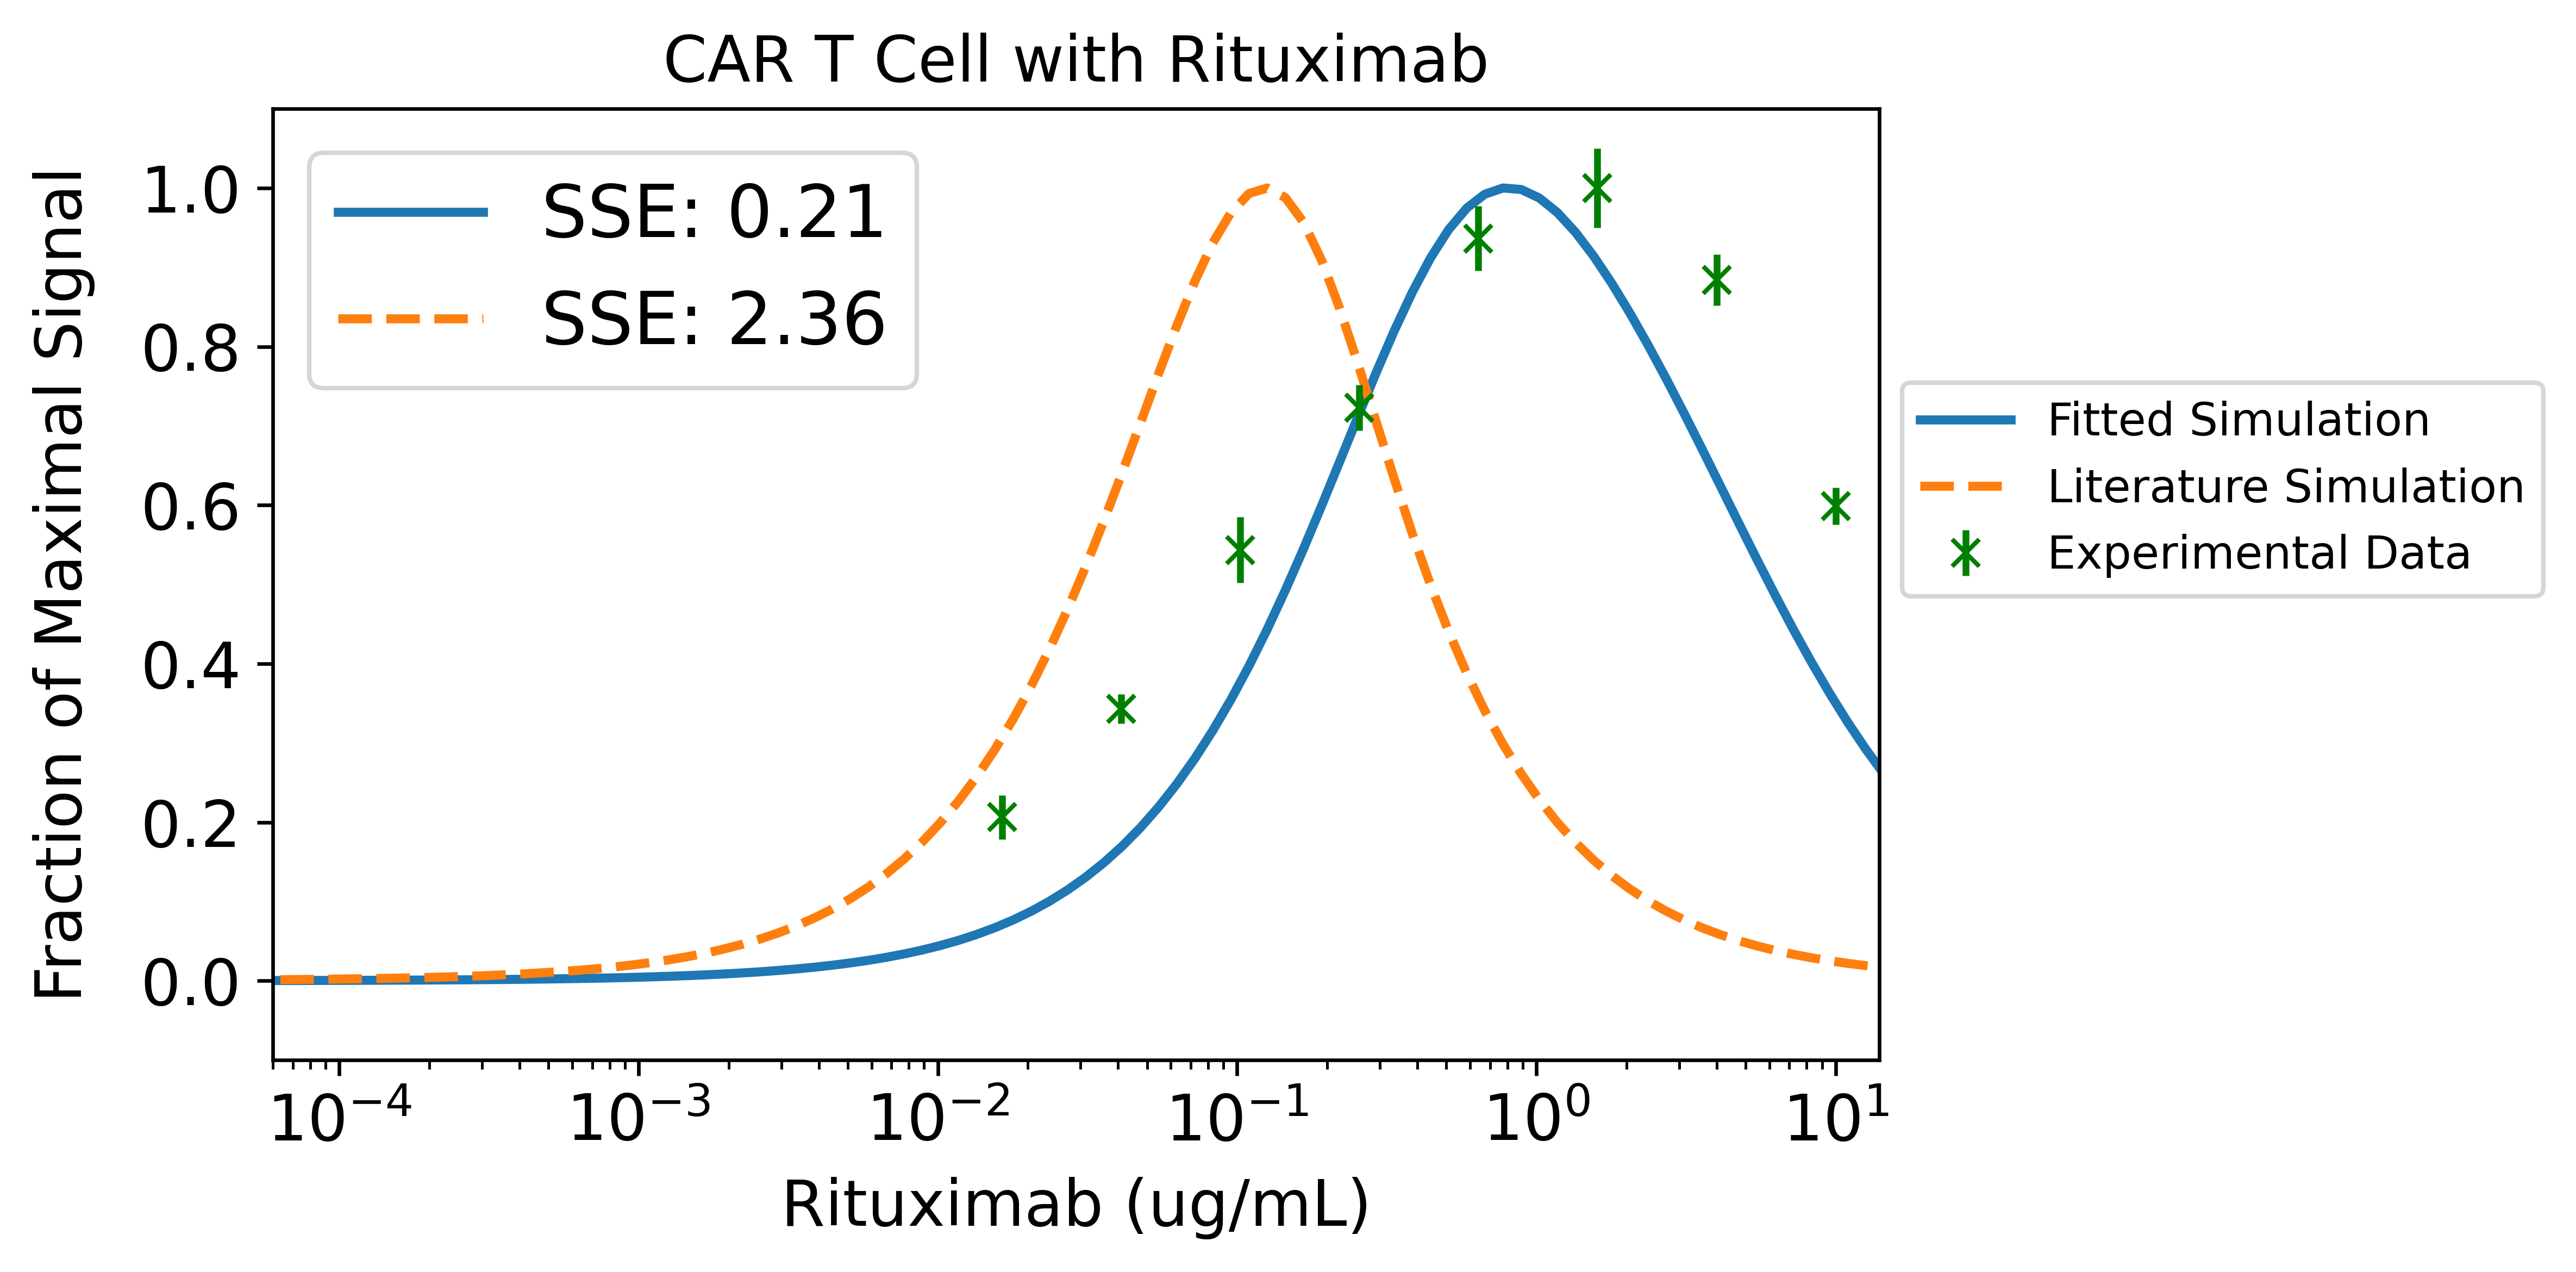

In [262]:
fig = plt.figure(figsize=(8, 4), dpi=600)
gs1 = gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs1[0])

lines = []
lines += ax.plot(x_cont,y_fit,linewidth=2.0,label='Fitted Simulation')
lines += ax.plot(x_cont,y_hat_cont,'--',linewidth=2.0,label='Literature Simulation')

# ax.plot(x_dots,y_actual_dots,linewidth=2.0,label='Experimental Data')
lines += ax.errorbar(df_data, df_ydata, yerr=df_yerror, fmt='xg',label='Experimental Data')

ax.set_xscale('log')
plt.ylim([-0.1,1.1])
plt.xlim([6*10**-5,1.4*10**1])

if experiment.split("_")[0] == "SN": test = "SynNotch with "
else: test = "CAR T Cell with "
        
title = test + str(experiment.split("_")[1])
x_label = str(experiment.split("_")[1]) + ' (ug/mL)'

plt.title(title, fontsize=14)
plt.xlabel(x_label, fontsize=14,labelpad=5)
plt.ylabel('Fraction of Maximal Signal', fontsize=14,labelpad=10)

ttl = ax.title
ttl.set_position([.5, 1.05])

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14)
    
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)

# Shrink current axis by 10%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.6))
leg = Legend(ax, lines[0:2], ['SSE: '+str(error_after),'SSE: '+str(error_before)], loc='center left', bbox_to_anchor=(0, 0.83), fontsize=16)
ax.add_artist(leg)
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.3))

#Creating the plot, saving it, and showing it
gs1.tight_layout(fig)
gs1.tight_layout(fig, rect=[0, 0, 1, 1])
plt.savefig('Figures/A_Antibody_pngs/' + str(experiment) + '.png')
plt.savefig('Figures/B_Antibody_svgs/' + str(experiment) + '.svg', format='svg')

plt.show()